# Model of auxotrophic communities with mutations in update and production rates of amino acids

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))


## Community class definition
We start with defining a python class that describes community using equation from van Vliet et al Plos Comp Bio 2022.
You do not need to modify anything here

In [3]:
class community:
    """Class for a community of auxotrophs"""

    def __init__(self, c_up=1, c_prod=1):
        """Initialize the community with a set of parameters
        
            c_up: factor that scales uptake rate of pro in dPro
            c_prod: factor that scales production rate of trp in dPro
        
        """
            
        self.upPro = 2.04 
        self.upTrp = 24.05 
        self.DiffP = 879 
        self.DiffT = 659 
        self.lPro = 1.59e-5
        self.lTrp = 6.04e-7 
        self.ic = 20 
        self.mu0 = 1.29/3600 
        self.rho = 0.65 
        self.rho2d = 0.22 
        self.cell_l = 5.2 
        self.cell_w = 0.68 
        self.beta = 0.88
        
        self.c_up = c_up
        self.c_prod = c_prod
        
        #DP depends on Pro, producer of Pro is DT, non-producer is DP
        self.muP = self.calc_mu_max(up_auxo = self.upPro * self.c_up, 
                                    leak_auxo = self.lPro, 
                                    up_prod = self.upPro, 
                                    leak_prod = self.lPro)
        
        self.rangeP = self.calc_int_range(up_auxo = self.upPro * self.c_up, 
                                          leak_auxo = self.lPro, 
                                          up_prod = self.upPro, 
                                          leak_prod = self.lPro,
                                          D = self.DiffP)
        
        self.nbP = self.calc_int_nb(self.rangeP)
        
        #DT depends on Trp, producer of Trp is DP, non-producer is DT
        self.muT = self.calc_mu_max(up_auxo = self.upTrp, 
                                    leak_auxo = self.lTrp, 
                                    up_prod = self.upTrp, 
                                    leak_prod = self.lTrp * self.c_prod)
        
        self.rangeT = self.calc_int_range(up_auxo = self.upTrp, 
                                          leak_auxo = self.lTrp, 
                                          up_prod = self.upTrp, 
                                          leak_prod = self.lTrp * self.c_prod,
                                          D = self.DiffT)        
        
        self.nbT = self.calc_int_nb(self.rangeT)
        
        self.calc_eq_prop() 
    
    
    def calc_mu_max(self, up_auxo=1, up_prod=1, leak_auxo=1, leak_prod=1):
        """Calculate the maximum growth rate of the cell"""
        theta = ((leak_prod * self.ic)/(2 * self.mu0)) * ((up_auxo + leak_auxo)/(up_prod + leak_prod))
        mu_max = self.mu0 * theta * (np.sqrt(1 + 2 / theta) - 1)        
        return 3600*mu_max
    
    def calc_int_range(self, up_auxo=1, up_prod=1, leak_auxo=1, leak_prod=1, D=1):
        '''calculate the interaction range of the cell'''
        theta = ((leak_prod * self.ic)/(2 * self.mu0)) * ((up_auxo + leak_auxo)/(up_prod + leak_prod))
        delta = theta * (2 * np.sqrt(up_prod + leak_prod)) / (np.sqrt(up_auxo + leak_auxo) + np.sqrt(up_prod + leak_prod))
        effective_D = D * (1 - self.rho)**2 / (self.rho * (1 + self.rho / 2))
        range = self.beta * np.sqrt( (effective_D) / (up_auxo + leak_auxo)) *  np.log(4 + delta * (1 + np.sqrt(1 + 4/delta)))
        return range
    
    def calc_int_nb(self, range):
        '''convert interaction range to number of neighbors'''
        range = (2 * range * (self.cell_l - self.cell_w) + np.pi * (range + self.cell_w/2)**2 - np.pi * (self.cell_w/2)**2) * self.rho2d
        return np.round(range)
        
    def calc_eq_prop(self):
        '''calculate equilibrium frequency of the community'''
        self.eq = (self.muT * (self.nbT - 2)/self.nbT + (self.muT/self.nbT - self.muP/self.nbP)) / (self.muT * (self.nbT - 2)/self.nbT + self.muP * (self.nbP - 2)/self.nbP)
        self.eq_wm = self.muT / (self.muT + self.muP)      
        
        self.clusteringT = (self.nbT - 2) / (self.nbT - 1)
        self.clusteringP = (self.nbP - 2) / (self.nbP - 1)

        pT = self.eq
        pP = 1-self.eq
        pPT = self.clusteringT * pP 
        pTP = self.clusteringP * pT
        growth = pT * pPT * self.muT + pP * pTP * self.muP
        growth_wm = self.eq_wm * (1-self.eq_wm) * self.muT + (1-self.eq_wm) * self.eq_wm * self.muP
                
        self.rel_growth = growth / growth_wm
        
        return None
    
    def report_properties(self):
        '''report properties of the community'''
        print(f"Frequency dT = {self.eq:.2f}")
        print(f"Clustering dT = {self.clusteringT:.2f}, Clustering dP = {self.clusteringP:.2f}")
        print(f"Growth defect spatial community = {self.rel_growth:.2f}")        
        print(f"mu_max dP = {self.muP:.2f}, mu_max dT = {self.muT:.2f}")
        print(f"range dP = {self.rangeP:.2f}um, range dT = {self.rangeT:.2f}um")
        
        return None
            


## Check original community

We can now check the properties of the original community to confirm we find the same values as in table S3 of our paper.
There are minor differences as there was a small error in our paper in the conversion of interaction range to number of neighbors

In [4]:
wt_community = community()
wt_community.report_properties()

Frequency dT = 0.20
Clustering dT = 0.90, Clustering dP = 0.99
Growth defect spatial community = 0.92
mu_max dP = 0.77, mu_max dT = 0.22
range dP = 12.17um, range dT = 2.52um


## Check mutant communities

We can now check properties for the mutant strains. 

For the high uptake mutant we assume that  its uptake rate is increased by a factor c_up (>1), i.e. up_rate = c_up * up_Pro

For the over producing mutant we assume that its leakage rate is increased by factor c_prod (>1), i.e. leak_rate = c_prod * leak_Pro

Note: leakage flux is leakage rate * internal concentration, so increasing internal concentration trough over production rate is mathematical identical to increasing leakage rate in our model.

**Below you can change c_up and c_prod  to see how they affect the community properties.**

### Increased proline uptake mutant

In [5]:
mut_community1 = community(c_up=10, c_prod=1)
mut_community1.report_properties()

Frequency dT = 0.12
Clustering dT = 0.90, Clustering dP = 0.96
Growth defect spatial community = 0.78
mu_max dP = 1.17, mu_max dT = 0.22
range dP = 4.96um, range dT = 2.52um


### Tryptophan overproduction mutant

In [6]:
mut_community1 = community(c_up=1, c_prod=200)
mut_community1.report_properties()

Frequency dT = 0.60
Clustering dT = 0.96, Clustering dP = 0.99
Growth defect spatial community = 0.97
mu_max dP = 0.77, mu_max dT = 1.14
range dP = 12.17um, range dT = 4.37um


### Increased proline uptake & tryptophan overproduction mutant 

In [7]:
mut_community1 = community(c_up=10, c_prod=200)
mut_community1.report_properties()

Frequency dT = 0.49
Clustering dT = 0.96, Clustering dP = 0.96
Growth defect spatial community = 0.96
mu_max dP = 1.17, mu_max dT = 1.14
range dP = 4.96um, range dT = 4.37um


## Plot figures

### Heatmap of changing uptake vs changing production

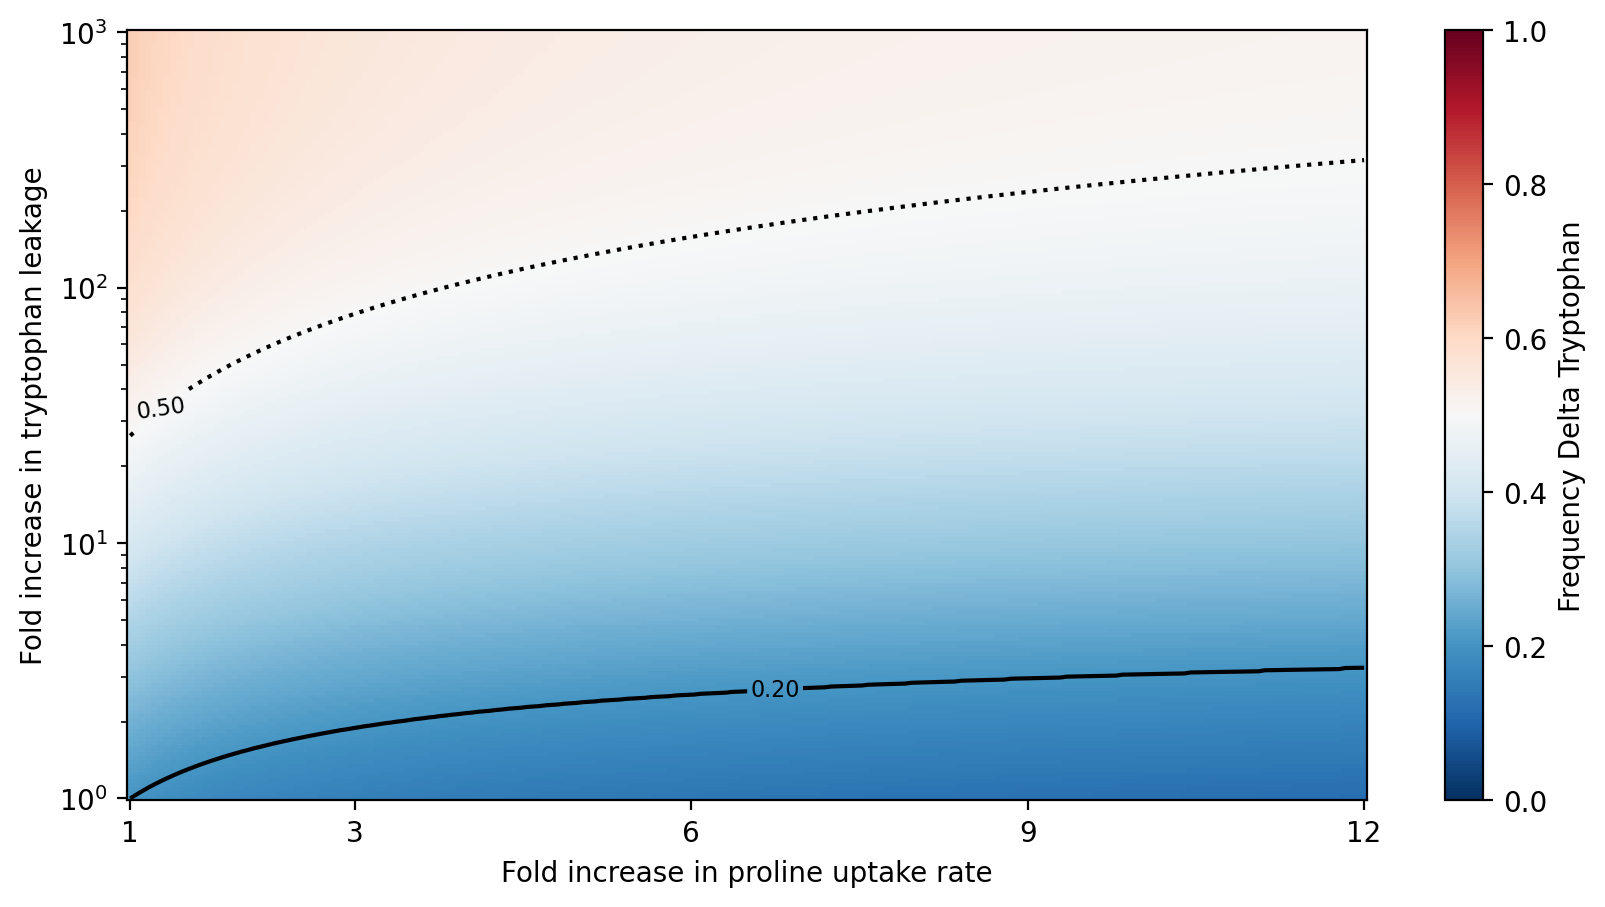

In [12]:
#SET Range of parameters to plot
nstep = 200 
c_up_vec = np.linspace(1,12,nstep) #increase uptake rate from 1 to 12 fold, on lin scale
c_prod_vec = np.logspace(0,3,nstep) #increase production/leakage rate from 1 to 100 fold, on log scale

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_scan = community(c_up=c_up, c_prod=c_prod)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
f1 = ax.pcolormesh(c_up_vec, c_prod_vec, community_scan.eq, cmap='RdBu_r', vmin=0, vmax=1, edgecolors='face')
#add contour line of original community and 50% frequency
f2 = ax.contour(c_up_vec, c_prod_vec, community_scan.eq, levels=[wt_community.eq,0.5], colors='k',linestyles=['solid','dotted'])
ax.clabel(f2, inline=True, fontsize=8, fmt='%.2f')
#set y-axis to log scale
plt.yscale('log')
#add colorbar
cb = plt.colorbar(f1)
#add labels
cb.set_label('Frequency Delta Tryptophan')
ax.set_xlabel('Fold increase in proline uptake rate')
ax.set_ylabel('Fold increase in tryptophan leakage')
ax.set_xticks([1,3,6,9,12]);

#save figure as pdf
plt.savefig('frequency_heatmap.pdf', bbox_inches='tight')

### Line plots increasing tryptophan production rate

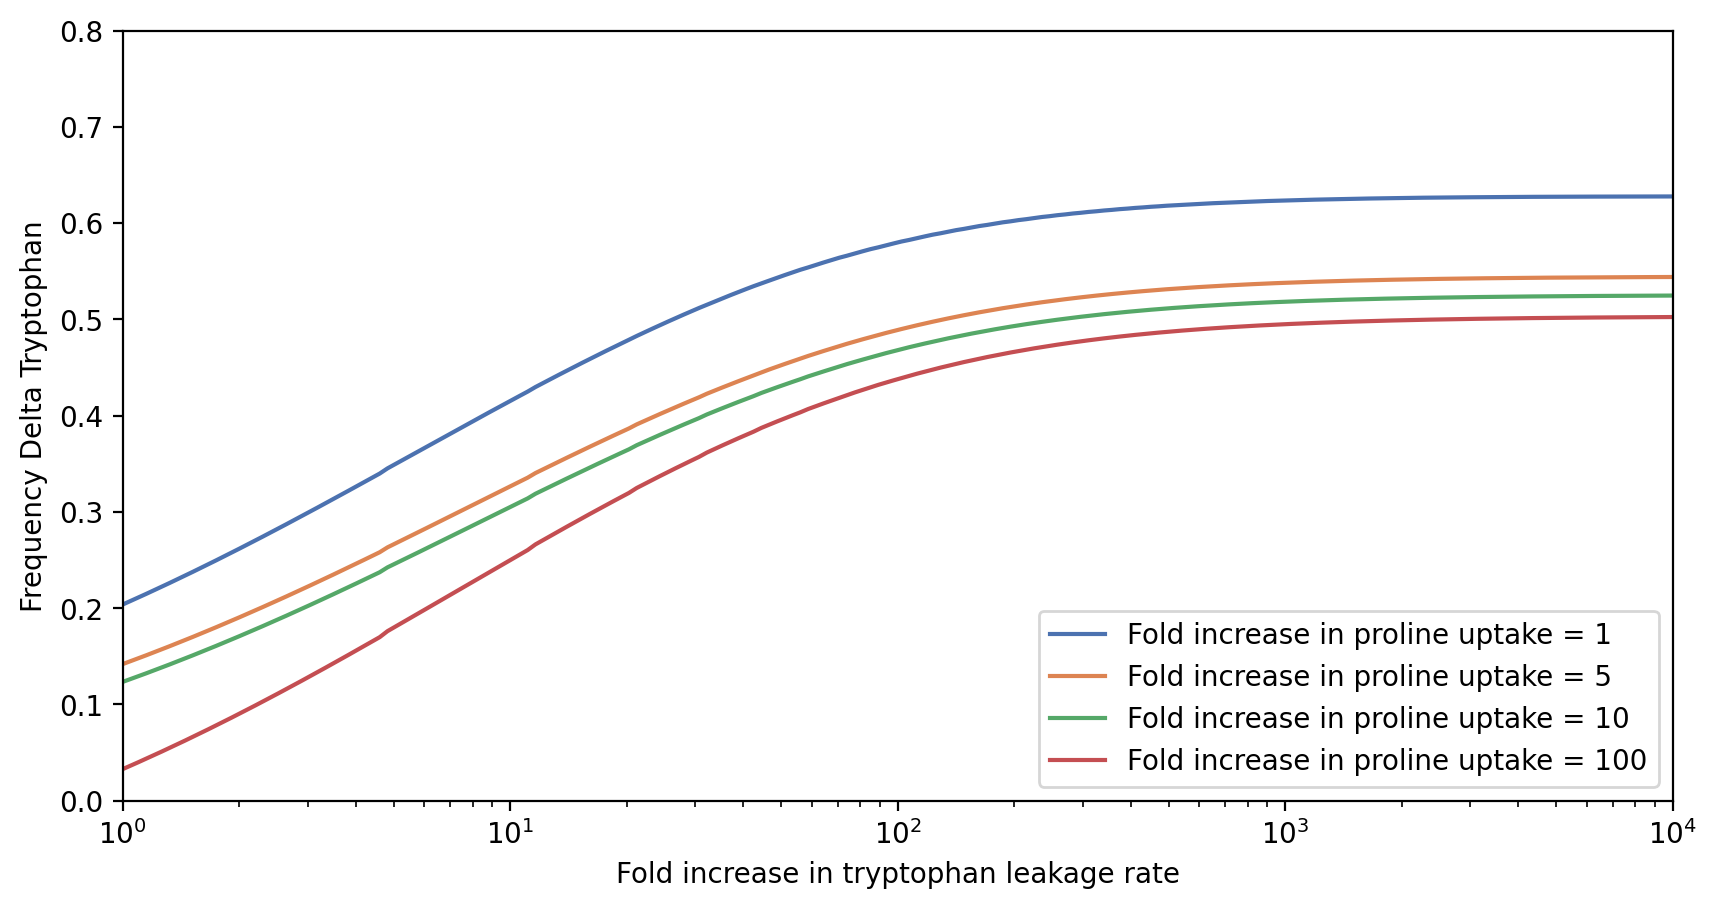

In [48]:
nstep = 200 
c_up_vec = np.array([1,5,10,100]) #compare 3 different rates of proline uptake
c_prod_vec = np.logspace(0,4,nstep) #increase production/leakage rate from 1 to 100 fold, on log scale

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_upscan = community(c_up=c_up, c_prod=c_prod)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
sns.set_palette('deep')
ax.plot(c_prod_vec, community_upscan.eq);
#add legend based in c_prod_vec
ax.legend([f'Fold increase in proline uptake = {x}' for x in c_up_vec], loc='lower right')
ax.set_xscale('log')
ax.set_xlim([c_prod_vec.min(),c_prod_vec.max()])
ax.set_ylim([0,0.8])
ax.set_xlabel('Fold increase in tryptophan leakage rate')
ax.set_ylabel('Frequency Delta Tryptophan')

plt.savefig('frequency_vs_uptake.pdf', bbox_inches='tight')

### Line plots increasing proline uptake rate

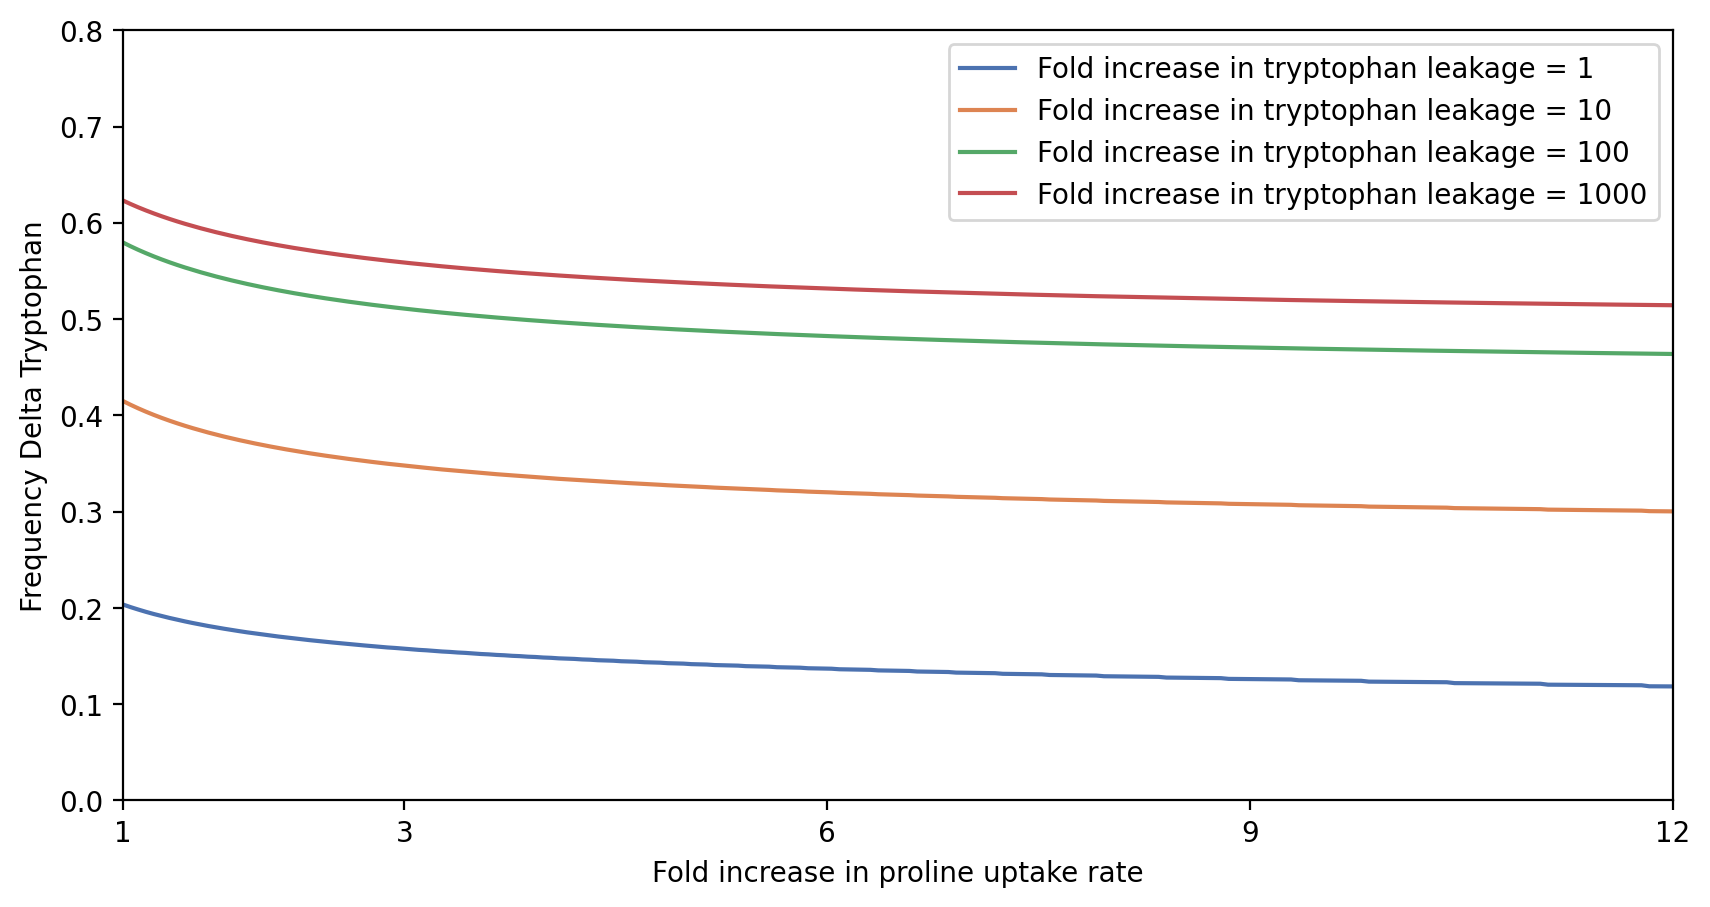

In [43]:
nstep = 200 
c_up_vec = np.linspace(1,12,nstep) #increase uptake rate from 1 to 12 fold, on lin scale
c_prod_vec = [1,10,100,1000] # compare 4 different rates of tryptophan leakage

#calculate equilibrium frequency for all combinations of parameters
c_up, c_prod = np.meshgrid(c_up_vec, c_prod_vec)
community_upscan = community(c_up=c_up, c_prod=c_prod)

#plot heatmap of equilibrium frequency
fig, ax = plt.subplots()
sns.set_palette('deep')
ax.plot(c_up_vec, community_upscan.eq.T);
#add legend based in c_prod_vec
ax.legend([f'Fold increase in tryptophan leakage = {x}' for x in c_prod_vec], loc='upper right')
ax.set_xlim([c_up_vec.min(),c_up_vec.max()])
ax.set_ylim([0,0.8])
ax.set_xlabel('Fold increase in proline uptake rate')
ax.set_ylabel('Frequency Delta Tryptophan')
ax.set_xticks([1,3,6,9,12]);

plt.savefig('frequency_vs_uptake.pdf', bbox_inches='tight')